<a href="https://colab.research.google.com/github/sayakpaul/Generalized-ODIN-TF/blob/main/Generalized_ODIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
import os
import urllib
from getpass import getpass

user = input('User name: ')
password = getpass('Password: ')
password = urllib.parse.quote(password)
repo_address = input('Repo Address: ')
branch_name = input('Branch name: ')

cmd_string = 'git clone https://{}:{}@github.com/{}.git -b {}'.format(
    user, password, repo_address, branch_name
)

os.system(cmd_string)
cmd_string, password = "", ""

User name: sayakpaul
Password: ··········
Repo Address: sayakpaul/Generalized-ODIN-TF
Branch name: main


In [1]:
import sys
sys.path.append("Generalized-ODIN-TF")

import resnet20_odin

from tensorflow.keras import layers
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(42)
np.random.seed(42)

## Load CIFAR10

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

Total training examples: 50000
Total test examples: 10000


## Define constants

In [3]:
BATCH_SIZE = 128
EPOCHS = 200
START_LR = 0.1
AUTO = tf.data.AUTOTUNE

## Prepare data loaders

In [4]:
# Augmentation pipeline
simple_aug = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ]
)

# Now, map the augmentation pipeline to our training dataset
train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

## Utility function for the model

In [5]:
def get_rn_model(num_classes=10):
    n = 2
    depth = n * 9 + 2
    n_blocks = ((depth - 2) // 9) - 1

    # The input tensor
    inputs = layers.Input(shape=(32, 32, 3))
    x = layers.experimental.preprocessing.Rescaling(scale=1.0 / 127.5, offset=-1)(
        inputs
    )

    # The Stem Convolution Group
    x = resnet20_odin.stem(x)

    # The learner
    x = resnet20_odin.learner(x, n_blocks)

    # The Classifier for 10 classes
    outputs = resnet20_odin.classifier(x, num_classes)

    # Instantiate the Model
    model = tf.keras.Model(inputs, outputs)
    return model

## Define LR schedule, optimizer, and loss function

In [6]:
def lr_schedule(epoch):
    if epoch < int(EPOCHS * 0.5) - 1:
        return START_LR
    elif epoch < int(EPOCHS*0.75) -1:
        return float(START_LR * 0.1)
    else:
        return float(START_LR * 0.01)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_schedule(epoch), verbose=True)

In [7]:
# Optimizer and loss function.
optimizer = tf.keras.optimizers.SGD(learning_rate=START_LR, momentum=0.9)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

## Model training with ResNet20

In [8]:
odin_rn_model = get_rn_model()
odin_rn_model.compile(loss=loss_fn, optimizer=optimizer)
history = odin_rn_model.fit(train_ds,
               epochs=EPOCHS,
               callbacks=[lr_callback])

Epoch 1/200

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
391/391 [==============================] - 16s 33ms/step - loss: 8.1664
Epoch 2/200

Epoch 00002: LearningRateScheduler reducing learning rate to 0.1.
391/391 [==============================] - 13s 33ms/step - loss: 4.9656
Epoch 3/200

Epoch 00003: LearningRateScheduler reducing learning rate to 0.1.
391/391 [==============================] - 13s 33ms/step - loss: 3.4281
Epoch 4/200

Epoch 00004: LearningRateScheduler reducing learning rate to 0.1.
391/391 [==============================] - 13s 33ms/step - loss: 2.6990
Epoch 5/200

Epoch 00005: LearningRateScheduler reducing learning rate to 0.1.
391/391 [==============================] - 13s 33ms/step - loss: 2.2887
Epoch 6/200

Epoch 00006: LearningRateScheduler reducing learning rate to 0.1.
391/391 [==============================] - 13s 33ms/step - loss: 2.0135
Epoch 7/200

Epoch 00007: LearningRateScheduler reducing learning rate to 0.1.
391/391 [======

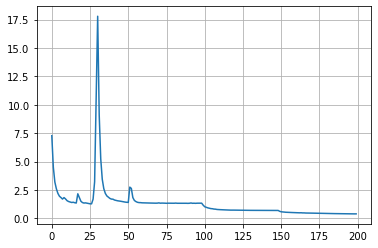

INFO:tensorflow:Assets written to: odin_rn_model/assets


In [9]:
plt.plot(history.history["loss"])
plt.grid()
plt.show()

odin_rn_model.save("odin_rn_model")